# Travail sur la ponctualité des trains

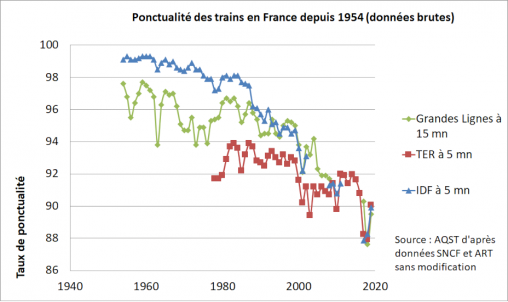

In [86]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np
import re
import matplotlib.pyplot as plt
import pprint
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [87]:
from sklearn import svm
import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [88]:
"""
#si erreur "Max retries exceeded with url"

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

session.get(url_retards)
"""

'\n#si erreur "Max retries exceeded with url"\n\nimport requests\nfrom requests.adapters import HTTPAdapter\nfrom urllib3.util.retry import Retry\n\nsession = requests.Session()\nretry = Retry(connect=3, backoff_factor=0.5)\nadapter = HTTPAdapter(max_retries=retry)\nsession.mount(\'http://\', adapter)\nsession.mount(\'https://\', adapter)\n\nsession.get(url_retards)\n'

In [480]:
#importation des donnees
url_retards ='https://ressources.data.sncf.com/api/v2/catalog/datasets/regularite-mensuelle-tgv-aqst/exports/json?limit=-1&offset=0&timezone=UTC'
retards = requests.get(url_retards)
wb_retards = retards.json()

df_retards = pd.DataFrame(wb_retards)

In [481]:
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,None,213,8.479969,...,32,5.363539,9,4,20.000000,35.000000,16.666667,16.666667,8.333333,3.333333
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,None,193,7.294991,...,56,7.225734,29,11,37.333333,26.666667,21.333333,4.000000,9.333333,1.333333


In [482]:
#on retire les colonnes de commentaires qui sont generalement vides
df_retards = df_retards.drop('commentaire_annulation', axis = 1)
df_retards = df_retards.drop('commentaire_retards_depart', axis = 1)
df_retards = df_retards.drop('commentaires_retard_arrivee', axis = 1)


In [483]:
#on retire aussi les colonnes de NaN et dont les retards valent 0 qui ne nous interessent pas ici
df_retards.dropna(inplace = True)
df_retards = df_retards.drop(df_retards[df_retards['retard_moyen_arrivee']==0].index)


In [540]:
#on copie la dataframe initiale par securite
#df_retards_initial = df_retards.copy()
df_retards = df_retards_initial.copy()
df_retards

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,213,8.479969,4.567119,...,32,5.363539,9,4,20.000000,35.000000,16.666667,16.666667,8.333333,3.333333
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,193,7.294991,2.720211,...,56,7.225734,29,11,37.333333,26.666667,21.333333,4.000000,9.333333,1.333333
2,2018-01,National,PARIS MONTPARNASSE,ANGERS SAINT LAUD,90,385,3,49,8.362585,0.730105,...,22,4.249433,8,1,21.428571,23.809524,21.428571,23.809524,9.523810,0.000000
3,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,37,9.501351,1.003981,...,26,7.548387,17,7,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
4,2018-01,National,POITIERS,PARIS MONTPARNASSE,94,472,4,224,6.784673,3.229701,...,42,4.882372,10,0,15.789474,45.614035,19.298246,15.789474,1.754386,1.754386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6932,2022-08,National,PARIS MONTPARNASSE,NANTES,130,584,5,68,15.297059,1.453080,...,39,51.619658,25,11,40.909091,2.272727,15.909091,22.727273,2.272727,15.909091
6933,2022-08,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,62,509,0,53,10.325786,0.677472,...,24,27.609028,11,0,2.040816,10.204082,26.530612,42.857143,6.122449,12.244898
6934,2022-08,National,PARIS MONTPARNASSE,TOURS,74,167,0,16,12.529167,0.835529,...,9,27.550000,3,0,0.000000,8.333333,16.666667,50.000000,8.333333,16.666667
6935,2022-08,National,SAINT ETIENNE CHATEAUCREUX,PARIS LYON,169,119,0,34,4.072549,1.626754,...,11,27.900000,3,0,28.571429,9.523810,28.571429,23.809524,0.000000,9.523810


In [543]:
df_retards['cause_materiel_roulant'] = df_retards['prct_cause_materiel_roulant']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_infra'] = df_retards['prct_cause_infra']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_gestion_trafic'] = df_retards['prct_cause_gestion_trafic']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_externe'] = df_retards['prct_cause_externe']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_gestion_gare'] = df_retards['prct_cause_gestion_gare']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_prise_en_charge_voyageurs'] = df_retards['prct_cause_prise_en_charge_voyageurs']/100*df_retards['nb_train_retard_arrivee']
df_retards

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,213,8.479969,4.567119,...,16.666667,16.666667,8.333333,3.333333,17.500000,36.750000,17.500000,21.000000,8.750000,3.500000
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,193,7.294991,2.720211,...,21.333333,4.000000,9.333333,1.333333,3.360000,22.400000,17.920000,31.360000,7.840000,1.120000
2,2018-01,National,PARIS MONTPARNASSE,ANGERS SAINT LAUD,90,385,3,49,8.362585,0.730105,...,21.428571,23.809524,9.523810,0.000000,12.380952,12.380952,11.142857,11.142857,4.952381,0.000000
3,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,37,9.501351,1.003981,...,15.384615,19.230769,0.000000,0.000000,5.000000,10.000000,4.000000,7.000000,0.000000,0.000000
4,2018-01,National,POITIERS,PARIS MONTPARNASSE,94,472,4,224,6.784673,3.229701,...,19.298246,15.789474,1.754386,1.754386,14.052632,40.596491,17.175439,14.052632,1.561404,1.561404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6932,2022-08,National,PARIS MONTPARNASSE,NANTES,130,584,5,68,15.297059,1.453080,...,15.909091,22.727273,2.272727,15.909091,10.227273,1.022727,7.159091,18.409091,1.022727,7.159091
6933,2022-08,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,62,509,0,53,10.325786,0.677472,...,26.530612,42.857143,6.122449,12.244898,23.142857,5.510204,14.326531,1.102041,3.306122,6.612245
6934,2022-08,National,PARIS MONTPARNASSE,TOURS,74,167,0,16,12.529167,0.835529,...,16.666667,50.000000,8.333333,16.666667,7.500000,1.250000,2.500000,0.000000,1.250000,2.500000
6935,2022-08,National,SAINT ETIENNE CHATEAUCREUX,PARIS LYON,169,119,0,34,4.072549,1.626754,...,28.571429,23.809524,0.000000,9.523810,5.000000,2.000000,6.000000,6.000000,0.000000,2.000000


In [546]:
#on somme à présent les données par mois
causes_retards = ['cause_materiel_roulant', 'cause_infra', 'cause_gestion_trafic', 'cause_externe', 'cause_gestion_gare', 'cause_prise_en_charge_voyageurs']
df_retards = df_retards.groupby(['date'])[['retard_moyen_arrivee','cause_materiel_roulant', 'cause_infra', 'cause_gestion_trafic', 'cause_externe', 'cause_gestion_gare', 'cause_prise_en_charge_voyageurs', 'nb_train_retard_arrivee']].mean()
df_retards.head()


,retard_moyen_arrivee,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs,nb_train_retard_arrivee
date,,,,,,,,
2018-01,4297.812206,963.186734,1619.253877,886.552655,1455.336884,217.537159,136.132691,5278.0
2018-02,4587.555526,1183.780599,1301.197893,1128.437080,3004.755592,238.363733,84.465103,6941.0
2018-03,4286.164830,1140.311249,1098.606087,1067.233964,1491.275701,307.113105,130.459895,5236.0
2018-04,3763.857204,810.473878,969.274613,746.581661,1104.847987,292.943362,141.878499,4066.0
2018-05,4306.533128,885.380020,750.015908,670.263308,1586.635265,252.481855,191.223644,4728.0


In [547]:
#voir s'il faudrait prendre la somme des retards

<font color='blue'> **Première regression linéaire à une varaible** </font>

In [548]:
x = df_retards[['cause_gestion_gare']]
y = df_retards[['retard_moyen_arrivee']].values.ravel()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2)
xTest

,cause_gestion_gare
date,
2020-11,70.762723
2019-05,198.821230
2018-01,217.537159
2021-01,246.095201
2021-09,451.798885
2022-08,490.080551
2019-06,409.263416
2019-09,260.094881
2020-05,57.071221


In [549]:
#on fait la regression lineaire
reg = LinearRegression()
reg.fit(xTrain, yTrain) #estime les coeffs
reg.coef_
reg.intercept_

3669.2696853294456

In [550]:
#puis on predit les resultats
yPred = reg.predict(xTest)
yPred

array([3781.98837956, 3985.97413923, 4015.78694245, 4061.27735214,
       4388.94494025, 4449.92421362, 4321.18973849, 4083.57759059,
       3760.17904089, 4095.85679215, 3978.05618431, 3869.22294473])

In [551]:
epsilon = yTest - yPred
print("R2 : ",reg.score(xTest, yTest))

R2 :  0.306208794347844


Text(0, 0.5, 'erreur de prediction')

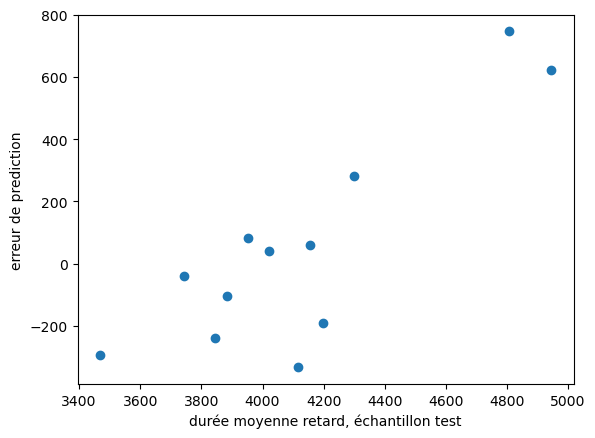

In [552]:
plt.scatter(yTest, epsilon)
plt.xlabel("durée moyenne retard, échantillon test")
plt.ylabel("erreur de prediction")
# La répartition des erreurs n'est pas aléatoire en fonction de x.
# Le modèle souffre donc d'un problème de spécification. 

<font color='blue'> **On ajoute maintenant des variables explicatives** </font>

<font color='blue'> **1. Regression linéaire** </font>

In [553]:
x = sm.add_constant(df_retards[causes_retards])
y = df_retards[['retard_moyen_arrivee']].values.ravel()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2)
xTest

,const,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
date,,,,,,,
2018-02,1.0,1183.780599,1301.197893,1128.437080,3004.755592,238.363733,84.465103
2020-07,1.0,585.168497,733.641136,726.245656,1121.171347,237.637682,112.135682
2018-05,1.0,885.380020,750.015908,670.263308,1586.635265,252.481855,191.223644
2022-06,1.0,1438.665198,1438.936303,1483.324174,1252.670563,669.964104,550.439658
2021-08,1.0,629.891715,525.383282,499.673594,695.841247,363.264899,709.945263
2020-02,1.0,606.959849,1223.900714,921.899520,860.449609,217.046331,90.743978
2022-05,1.0,966.559168,991.901539,1044.087414,820.463405,425.608375,598.380099
2018-06,1.0,1028.666574,1751.307609,966.506502,1639.143692,370.342774,165.032849
2019-11,1.0,848.768617,1205.210275,1104.764679,1140.446766,358.584025,173.225638


In [554]:
#on fait la regression lineaire

results = sm.OLS(yTrain, xTrain).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     2.977
Date:                Wed, 14 Dec 2022   Prob (F-statistic):             0.0179
Time:                        13:47:10   Log-Likelihood:                -336.50
No. Observations:                  44   AIC:                             687.0
Df Residuals:                      37   BIC:                             699.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Problème : coeffs non significatifs

In [555]:
#On évaluer la pertinence du modèle

# R^2: 1 corresponf à une prédiction parfaite
print("R2: ", results.rsquared)

R2:  0.3256128959852017


In [556]:
#puis on predit les resultats
#yPred = sm.predict(xTrain)
yPred = results.predict(xTest)
epsilon = yTest - yPred


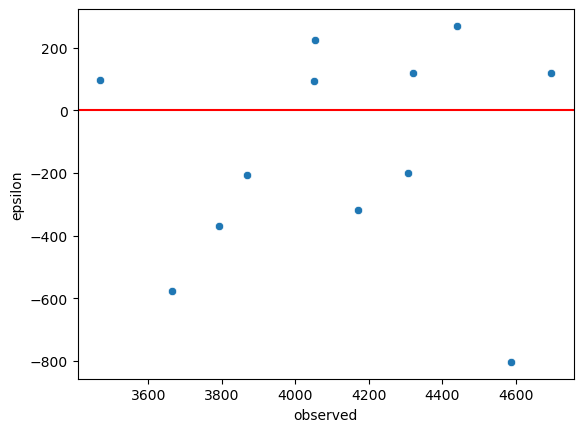

In [557]:
#Nuage de points des valeurs observées
tempdf = pd.DataFrame({"prediction": yPred, "observed": yTest,
                       "epsilon": yTest - yPred})

fig = plt.figure()
g = sns.scatterplot(data = tempdf, x = "observed", y = "epsilon")
g.axhline(0, color = "red")

#le modèle est meilleur avec plusieurs variables explicatives

<font color='blue'> **2. Regression logistique : a faire avec d'autres variables (binaires)** </font>

<font color='blue'> **Autre regression : le nombre de retards** </font>

In [71]:
#les coefficient pour le nombre de retards paraissent bizarre --> coefficients negatifs
#on va proceder au lasso pour selectionner les variables

https://sites.google.com/view/aide-python/statistiques/machine-learning-en-python/r%C3%A9gressions-lin%C3%A9aires-en-python?pli=1

- les nombres de retards sont moins bien prédits que les durées de retard par le modèle 
- les problèmes de materiel roulant sont ce qui causent les retards les plus importants (en durée)
- à priori, les problèmes de gestion de gare sont ce qui causent le plus de retards 


**a faire : reprendre ce travail de regression en suivant les etapes des exercices 3 et 4 de la partie 3 du cours**